In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme(style="whitegrid")

# Ejercicio 1
## Descripción:
En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.
## Dataset:
El dataset proporcionado incluye las siguientes variables para cada estudiante:
* Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
* Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
* Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
* Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.
Además, el dataset incluye la variable objetivo:
* Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.
## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.


## Carga de CSV y análisis

In [ ]:
df = pd.read_csv("Student_Performance.csv")

In [ ]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [ ]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

No hay valores nulos

<Figure size 640x480 with 0 Axes>

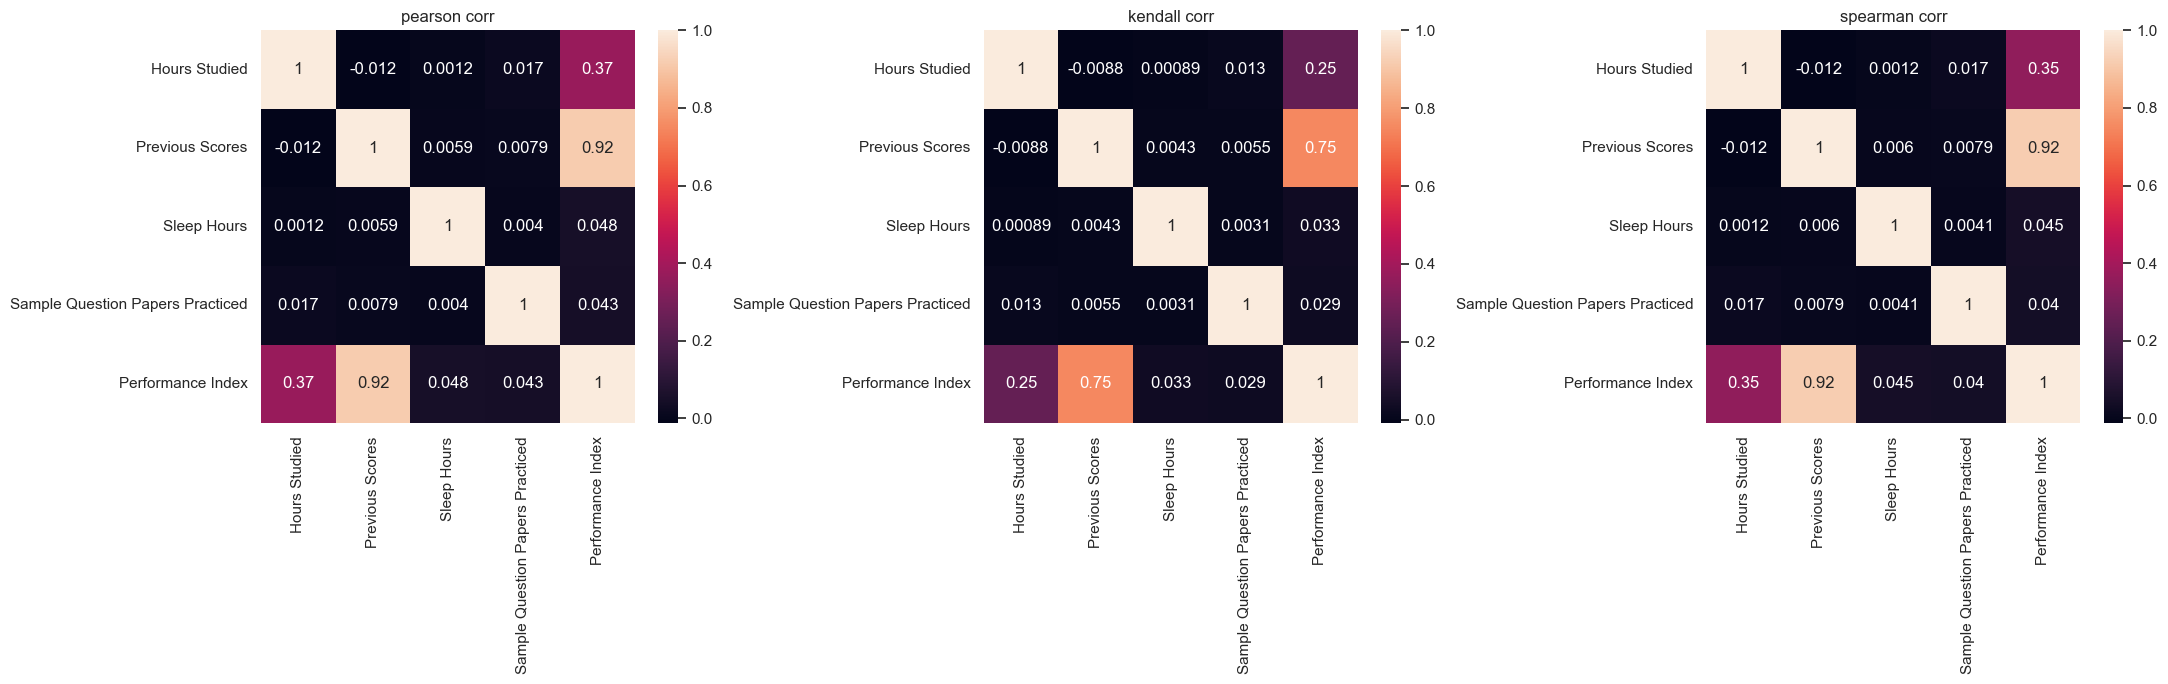

In [ ]:
methods = ["pearson", "kendall", "spearman"]
plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
for i, method in enumerate(methods):
    sbn.heatmap(df.corr(numeric_only=True, method=method), ax=axes[i], annot=True)
    axes[i].set_title(f"{method} corr")
plt.tight_layout()
plt.show()

Vemos que las variables descriptivas que más van a servir para realizar la predicción de *Performance Index* son **Hours Studied** y **Previous Scores**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='Hours Studied', ylabel='Performance Index'>

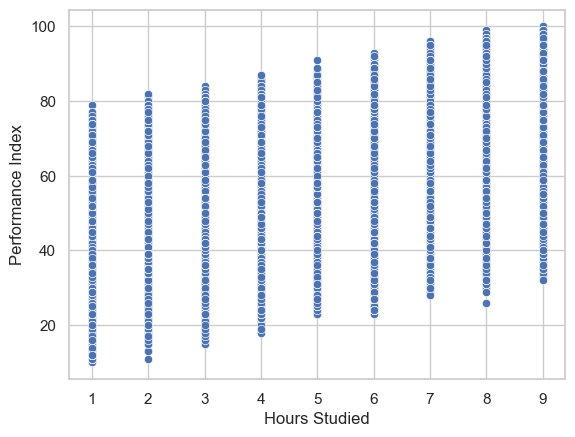

In [ ]:
sbn.scatterplot(df, x="Hours Studied", y="Performance Index")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='Previous Scores', ylabel='Performance Index'>

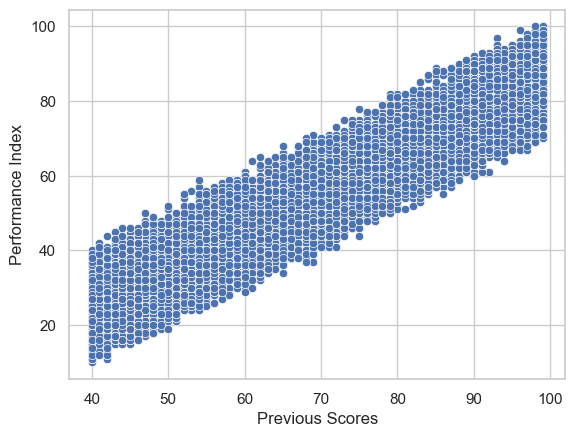

In [ ]:
sbn.scatterplot(df, x="Previous Scores", y="Performance Index")

In [ ]:
#Convertir variables categóricas a numéricas
df2 = df.copy()
df2["IsExtraAct"] = df["Extracurricular Activities"].apply(lambda x: 1 if x == 'Yes' else 0)
df2.drop(columns="Extracurricular Activities", inplace=True)

In [ ]:
df2.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,IsExtraAct
0,7,99,9,1,91.0,1
1,4,82,4,2,65.0,0
2,8,51,7,2,45.0,1
3,5,52,5,2,36.0,1
4,7,75,8,5,66.0,0


## Creación del modelo

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
import optuna
import os
import random

def set_seeds(seed):  #Setear seed para obtener siempre los mismos resultados
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
set_seeds(72)

In [ ]:
## Dividir dataset
#Se elimina la columna target
dfx = df2.drop(columns=["Performance Index"])
dfy = df2["Performance Index"]
X, X_test, y, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=72)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=72)

#### Fine-Tunning
Utilizamos la librería optuna para encontrar los mejores parámetros para el modelo.
Para ello necesitamos una función en donde vamos a definir nuestros posibles parámetros y luego retornamos el RMSE. El propósito es minimizar la función para quedarnos con el modelo que tenga el menor RMSE

In [ ]:
def objetivo_regresion(trial: optuna.trial.Trial):
    num_capas = trial.suggest_int("num_capas", 1, 4)
    model = Sequential()
    model.add(Input(shape=(len(X_train.columns), )))
    for i in range(num_capas):
        num_conexiones = trial.suggest_int(f"n_por_capas_{i}", 2, 10)
        model.add(Dense(num_conexiones, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [ ]:
estudio_reg = optuna.create_study(direction="minimize")
estudio_reg.optimize(objetivo_regresion, n_trials=10)

[I 2024-06-24 20:20:48,441] A new study created in memory with name: no-name-f33b01ed-79a1-4c0d-a188-bf956c5af078


Epoch 1/10
188/188 [==============================] - 0s 996us/step - loss: 925.2626 - rmse: 30.4181 - val_loss: 58.6090 - val_rmse: 7.6557
Epoch 2/10
188/188 [==============================] - 0s 668us/step - loss: 53.4400 - rmse: 7.3103 - val_loss: 43.8400 - val_rmse: 6.6212
Epoch 3/10
188/188 [==============================] - 0s 668us/step - loss: 44.1441 - rmse: 6.6441 - val_loss: 38.7707 - val_rmse: 6.2266
Epoch 4/10
188/188 [==============================] - 0s 685us/step - loss: 39.5623 - rmse: 6.2899 - val_loss: 34.8977 - val_rmse: 5.9074
Epoch 5/10
188/188 [==============================] - 0s 686us/step - loss: 35.5290 - rmse: 5.9606 - val_loss: 32.0393 - val_rmse: 5.6603
Epoch 6/10
188/188 [==============================] - 0s 663us/step - loss: 32.2080 - rmse: 5.6752 - val_loss: 29.2809 - val_rmse: 5.4112
Epoch 7/10
188/188 [==============================] - 0s 661us/step - loss: 29.5613 - rmse: 5.4370 - val_loss: 27.5030 - val_rmse: 5.2443
Epoch 8/10
188/188 [============

[I 2024-06-24 20:20:50,128] Trial 0 finished with value: 4.774425029754639 and parameters: {'num_capas': 4, 'n_por_capas_0': 9, 'n_por_capas_1': 8, 'n_por_capas_2': 2, 'n_por_capas_3': 2}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 981us/step - loss: 56.2201 - rmse: 7.4980 - val_loss: 48.0090 - val_rmse: 6.9289
Epoch 2/10
188/188 [==============================] - 0s 681us/step - loss: 45.2366 - rmse: 6.7258 - val_loss: 39.8398 - val_rmse: 6.3119
Epoch 3/10
188/188 [==============================] - 0s 666us/step - loss: 37.5560 - rmse: 6.1283 - val_loss: 33.3282 - val_rmse: 5.7731
Epoch 4/10
188/188 [==============================] - 0s 661us/step - loss: 32.7986 - rmse: 5.7270 - val_loss: 29.6627 - val_rmse: 5.4463
Epoch 5/10
188/188 [==============================] - 0s 637us/step - loss: 29.9027 - rmse: 5.4683 - val_loss: 27.8828 - val_rmse: 5.2804
Epoch 6/10
188/188 [==============================] - 0s 640us/step - loss: 28.1847 - rmse: 5.3089 - val_loss: 26.5644 - val_rmse: 5.1541
Epoch 7/10
188/188 [==============================] - 0s 647us/step - loss: 26.9366 - rmse: 5.1900 - val_loss: 26.0828 - val_rmse: 5.1071
Epoch 8/10
188/188 [==============

[I 2024-06-24 20:20:51,735] Trial 1 finished with value: 4.834166049957275 and parameters: {'num_capas': 3, 'n_por_capas_0': 4, 'n_por_capas_1': 2, 'n_por_capas_2': 8}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 920us/step - loss: 202.1259 - rmse: 14.2171 - val_loss: 85.8482 - val_rmse: 9.2654
Epoch 2/10
188/188 [==============================] - 0s 603us/step - loss: 88.4647 - rmse: 9.4056 - val_loss: 81.1090 - val_rmse: 9.0061
Epoch 3/10
188/188 [==============================] - 0s 603us/step - loss: 83.1185 - rmse: 9.1169 - val_loss: 75.8382 - val_rmse: 8.7085
Epoch 4/10
188/188 [==============================] - 0s 633us/step - loss: 77.6367 - rmse: 8.8112 - val_loss: 70.1975 - val_rmse: 8.3784
Epoch 5/10
188/188 [==============================] - 0s 623us/step - loss: 72.0420 - rmse: 8.4878 - val_loss: 64.8712 - val_rmse: 8.0543
Epoch 6/10
188/188 [==============================] - 0s 610us/step - loss: 66.6662 - rmse: 8.1649 - val_loss: 59.9489 - val_rmse: 7.7427
Epoch 7/10
188/188 [==============================] - 0s 602us/step - loss: 61.6039 - rmse: 7.8488 - val_loss: 55.1586 - val_rmse: 7.4269
Epoch 8/10
188/188 [============

[I 2024-06-24 20:20:53,212] Trial 2 finished with value: 6.77398681640625 and parameters: {'num_capas': 1, 'n_por_capas_0': 7}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 1ms/step - loss: 1468.8137 - rmse: 38.3251 - val_loss: 53.1295 - val_rmse: 7.2890
Epoch 2/10
188/188 [==============================] - 0s 694us/step - loss: 53.2786 - rmse: 7.2992 - val_loss: 48.4378 - val_rmse: 6.9597
Epoch 3/10
188/188 [==============================] - 0s 674us/step - loss: 48.9093 - rmse: 6.9935 - val_loss: 44.2417 - val_rmse: 6.6514
Epoch 4/10
188/188 [==============================] - 0s 672us/step - loss: 44.8658 - rmse: 6.6982 - val_loss: 40.3790 - val_rmse: 6.3544
Epoch 5/10
188/188 [==============================] - 0s 673us/step - loss: 41.2957 - rmse: 6.4262 - val_loss: 37.4636 - val_rmse: 6.1208
Epoch 6/10
188/188 [==============================] - 0s 676us/step - loss: 38.3460 - rmse: 6.1924 - val_loss: 35.1097 - val_rmse: 5.9253
Epoch 7/10
188/188 [==============================] - 0s 689us/step - loss: 36.0571 - rmse: 6.0048 - val_loss: 33.2860 - val_rmse: 5.7694
Epoch 8/10
188/188 [=============

[I 2024-06-24 20:20:54,892] Trial 3 finished with value: 5.62224006652832 and parameters: {'num_capas': 4, 'n_por_capas_0': 9, 'n_por_capas_1': 7, 'n_por_capas_2': 8, 'n_por_capas_3': 5}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 898us/step - loss: 1204.3735 - rmse: 34.7041 - val_loss: 223.9308 - val_rmse: 14.9643
Epoch 2/10
188/188 [==============================] - 0s 612us/step - loss: 104.0185 - rmse: 10.1989 - val_loss: 73.7794 - val_rmse: 8.5895
Epoch 3/10
188/188 [==============================] - 0s 627us/step - loss: 76.6672 - rmse: 8.7560 - val_loss: 70.9008 - val_rmse: 8.4203
Epoch 4/10
188/188 [==============================] - 0s 588us/step - loss: 73.5789 - rmse: 8.5778 - val_loss: 67.5884 - val_rmse: 8.2212
Epoch 5/10
188/188 [==============================] - 0s 601us/step - loss: 70.1201 - rmse: 8.3738 - val_loss: 64.1470 - val_rmse: 8.0092
Epoch 6/10
188/188 [==============================] - 0s 600us/step - loss: 66.4947 - rmse: 8.1544 - val_loss: 60.7012 - val_rmse: 7.7911
Epoch 7/10
188/188 [==============================] - 0s 599us/step - loss: 62.8458 - rmse: 7.9275 - val_loss: 57.1973 - val_rmse: 7.5629
Epoch 8/10
188/188 [=======

[I 2024-06-24 20:20:56,356] Trial 4 finished with value: 7.0600199699401855 and parameters: {'num_capas': 1, 'n_por_capas_0': 8}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 912us/step - loss: 2387.9336 - rmse: 48.8665 - val_loss: 1744.4873 - val_rmse: 41.7671
Epoch 2/10
188/188 [==============================] - 0s 603us/step - loss: 1105.4111 - rmse: 33.2477 - val_loss: 555.1427 - val_rmse: 23.5615
Epoch 3/10
188/188 [==============================] - 0s 603us/step - loss: 275.5300 - rmse: 16.5991 - val_loss: 108.9783 - val_rmse: 10.4393
Epoch 4/10
188/188 [==============================] - 0s 601us/step - loss: 78.0603 - rmse: 8.8352 - val_loss: 60.7202 - val_rmse: 7.7923
Epoch 5/10
188/188 [==============================] - 0s 602us/step - loss: 63.2995 - rmse: 7.9561 - val_loss: 58.5620 - val_rmse: 7.6526
Epoch 6/10
188/188 [==============================] - 0s 605us/step - loss: 62.2801 - rmse: 7.8918 - val_loss: 57.8500 - val_rmse: 7.6059
Epoch 7/10
188/188 [==============================] - 0s 611us/step - loss: 61.5445 - rmse: 7.8450 - val_loss: 57.1119 - val_rmse: 7.5572
Epoch 8/10
188/188 

[I 2024-06-24 20:20:57,817] Trial 5 finished with value: 7.584418296813965 and parameters: {'num_capas': 1, 'n_por_capas_0': 2}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 970us/step - loss: 3481.3743 - rmse: 59.0032 - val_loss: 3196.0889 - val_rmse: 56.5340
Epoch 2/10
188/188 [==============================] - 0s 622us/step - loss: 1668.3242 - rmse: 40.8451 - val_loss: 133.4814 - val_rmse: 11.5534
Epoch 3/10
188/188 [==============================] - 0s 625us/step - loss: 77.2456 - rmse: 8.7889 - val_loss: 67.6640 - val_rmse: 8.2258
Epoch 4/10
188/188 [==============================] - 0s 700us/step - loss: 70.6318 - rmse: 8.4043 - val_loss: 64.8685 - val_rmse: 8.0541
Epoch 5/10
188/188 [==============================] - 0s 624us/step - loss: 67.5754 - rmse: 8.2204 - val_loss: 61.6522 - val_rmse: 7.8519
Epoch 6/10
188/188 [==============================] - 0s 617us/step - loss: 63.7177 - rmse: 7.9823 - val_loss: 57.6070 - val_rmse: 7.5899
Epoch 7/10
188/188 [==============================] - 0s 652us/step - loss: 58.8254 - rmse: 7.6698 - val_loss: 52.4155 - val_rmse: 7.2399
Epoch 8/10
188/188 [===

[I 2024-06-24 20:20:59,387] Trial 6 finished with value: 6.290760517120361 and parameters: {'num_capas': 2, 'n_por_capas_0': 7, 'n_por_capas_1': 2}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 898us/step - loss: 1714.6942 - rmse: 41.4089 - val_loss: 278.3424 - val_rmse: 16.6836
Epoch 2/10
188/188 [==============================] - 0s 611us/step - loss: 117.4226 - rmse: 10.8362 - val_loss: 71.4374 - val_rmse: 8.4521
Epoch 3/10
188/188 [==============================] - 0s 610us/step - loss: 73.9944 - rmse: 8.6020 - val_loss: 67.7018 - val_rmse: 8.2281
Epoch 4/10
188/188 [==============================] - 0s 612us/step - loss: 70.3385 - rmse: 8.3868 - val_loss: 64.3227 - val_rmse: 8.0201
Epoch 5/10
188/188 [==============================] - 0s 613us/step - loss: 66.9311 - rmse: 8.1811 - val_loss: 61.0585 - val_rmse: 7.8140
Epoch 6/10
188/188 [==============================] - 0s 611us/step - loss: 63.4506 - rmse: 7.9656 - val_loss: 57.7897 - val_rmse: 7.6020
Epoch 7/10
188/188 [==============================] - 0s 609us/step - loss: 59.9353 - rmse: 7.7418 - val_loss: 54.4743 - val_rmse: 7.3807
Epoch 8/10
188/188 [=======

[I 2024-06-24 20:21:00,849] Trial 7 finished with value: 6.884092807769775 and parameters: {'num_capas': 1, 'n_por_capas_0': 9}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 899us/step - loss: 3317.3357 - rmse: 57.5963 - val_loss: 1173.9817 - val_rmse: 34.2634
Epoch 2/10
188/188 [==============================] - 0s 603us/step - loss: 459.7699 - rmse: 21.4422 - val_loss: 120.8142 - val_rmse: 10.9916
Epoch 3/10
188/188 [==============================] - 0s 603us/step - loss: 88.0640 - rmse: 9.3842 - val_loss: 75.0821 - val_rmse: 8.6650
Epoch 4/10
188/188 [==============================] - 0s 598us/step - loss: 77.5763 - rmse: 8.8077 - val_loss: 72.5488 - val_rmse: 8.5176
Epoch 5/10
188/188 [==============================] - 0s 602us/step - loss: 75.0173 - rmse: 8.6613 - val_loss: 69.9512 - val_rmse: 8.3637
Epoch 6/10
188/188 [==============================] - 0s 600us/step - loss: 72.4145 - rmse: 8.5097 - val_loss: 67.3608 - val_rmse: 8.2074
Epoch 7/10
188/188 [==============================] - 0s 612us/step - loss: 69.9113 - rmse: 8.3613 - val_loss: 64.8698 - val_rmse: 8.0542
Epoch 8/10
188/188 [====

[I 2024-06-24 20:21:02,300] Trial 8 finished with value: 7.772490501403809 and parameters: {'num_capas': 1, 'n_por_capas_0': 10}. Best is trial 0 with value: 4.774425029754639.


Epoch 1/10
188/188 [==============================] - 0s 900us/step - loss: 1733.0215 - rmse: 41.6296 - val_loss: 928.3862 - val_rmse: 30.4694
Epoch 2/10
188/188 [==============================] - 0s 589us/step - loss: 459.7991 - rmse: 21.4429 - val_loss: 180.1640 - val_rmse: 13.4225
Epoch 3/10
188/188 [==============================] - 0s 599us/step - loss: 106.7096 - rmse: 10.3300 - val_loss: 80.6138 - val_rmse: 8.9785
Epoch 4/10
188/188 [==============================] - 0s 610us/step - loss: 76.9132 - rmse: 8.7700 - val_loss: 75.0023 - val_rmse: 8.6604
Epoch 5/10
188/188 [==============================] - 0s 606us/step - loss: 73.6064 - rmse: 8.5794 - val_loss: 71.8340 - val_rmse: 8.4755
Epoch 6/10
188/188 [==============================] - 0s 591us/step - loss: 70.4930 - rmse: 8.3960 - val_loss: 68.5224 - val_rmse: 8.2778
Epoch 7/10
188/188 [==============================] - 0s 598us/step - loss: 67.2602 - rmse: 8.2012 - val_loss: 65.2831 - val_rmse: 8.0798
Epoch 8/10
188/188 [===

[I 2024-06-24 20:21:03,750] Trial 9 finished with value: 7.432929992675781 and parameters: {'num_capas': 1, 'n_por_capas_0': 2}. Best is trial 0 with value: 4.774425029754639.


In [ ]:
estudio_reg.best_params

{'num_capas': 4,
 'n_por_capas_0': 9,
 'n_por_capas_1': 8,
 'n_por_capas_2': 2,
 'n_por_capas_3': 2}

In [ ]:
estudio_reg.best_value

4.774425029754639

Utilizando **optuna** logramos un fine-tunning del modelo y obtuvimos los siguientes resultados:

**MODELO:**
* Número de capas: 1
* Neuronas capa 1: 7
  
**Mínimo RMSE:** 5.31

#### Creación del modelo

In [ ]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns), )))
model.add(Dense(units=7, activation="relu"))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 7)                 42        
                                                                 
 dense_64 (Dense)            (None, 1)                 8         
                                                                 
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/10
188/188 [==============================] - 0s 933us/step - loss: 1676.5183 - rmse: 40.9453 - val_loss: 663.6525 - val_rmse: 25.7615
Epoch 2/10
188/188 [==============================] - 0s 606us/step - loss: 284.2905 - rmse: 16.8609 - val_loss: 94.3014 - val_rmse: 9.7109
Epoch 3/10
188/188 [==============================] - 0s 610us/step - loss: 79.5215 - rmse: 8.9175 - val_loss: 70.4255 - val_rmse: 8.3920
Epoch 4/10
188/188 [==============================] - 0s 608us/step - loss: 73.9519 - rmse: 8.5995 - val_loss: 68.6992 - val_rmse: 8.2885
Epoch 5/10
188/188 [==============================] - 0s 611us/step - loss: 72.0708 - rmse: 8.4895 - val_loss: 66.7697 - val_rmse: 8.1713
Epoch 6/10
188/188 [==============================] - 0s 617us/step - loss: 69.9933 - rmse: 8.3662 - val_loss: 64.7039 - val_rmse: 8.0439
Epoch 7/10
188/188 [==============================] - 0s 606us/step - loss: 67.7863 - rmse: 8.2332 - val_loss: 62.5107 - val_rmse: 7.9064
Epoch 8/10
188/188 [=======

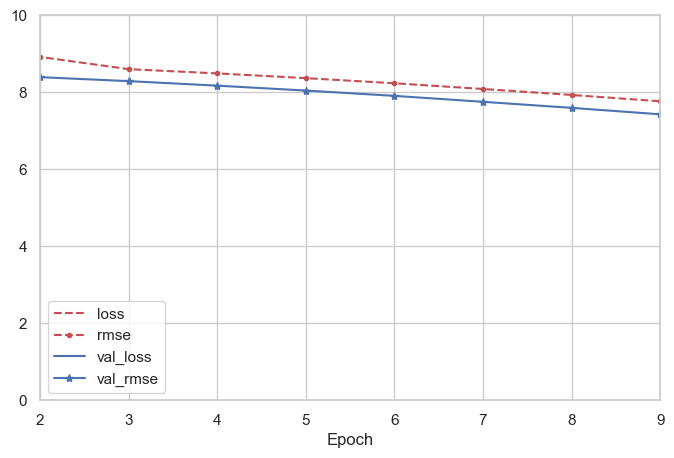

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8, 5), xlim=[2, 9], ylim=[0,10], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

Podemos ver que los valores de función de pérdida son más grandes a los de la pérdida de validación. Tambien vemos que los valores de RMSE, tanto para training como validation no van cambiando a lo largo del tiempo ya que desde la primer epoch tienen valores bajos. No contamos con overfitting

## Explicabilidad del modelo
Utilizando la librería de shap podemos ver qué tanto afectan las variables descriptivas a nuestro modelo

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[20,:])

Vemos que la hipótesis que habíamos realizado al principio en la que indicábamos que **Hours Studied** y **Previous Scores** iban a ser las más importantes al momento de realizar la predicción es verdadera

### Conclusión
Mediante este trabajo práctico hemos demostrado la viabilidad de utilizar redes neuronales para predecir el rendimiento académico de los estudiantes universitarios basándonos en diversas características como las horas de estudio, puntuaciones previas en exámenes, participación en actividades extracurriculares, horas de sueño, etc. Nuestro modelo de regresión neuronal ha demostrado una capacidad aceptable para predecir el índice de rendimiento académico, y mediante técnicas de validación y métricas de evaluación de regresión hemos verificado su precisión. Además, hemos utilizado SHAP para comprender la importancia y explicabilidad de las características en la predicción del rendimiento académico. Este enfoque podría tener aplicaciones prácticas en la identificación temprana de estudiantes que podrían necesitar apoyo adicional para mejorar su desempeño académico.

# Ejercicio 2
## Descripción:
En el siguiente problema, se presenta un conjunto de datos sobre diferentes variedades de frijoles secos. El objetivo es desarrollar un modelo de clasificación que pueda distinguir entre siete variedades registradas de frijoles secos, utilizando características como forma, tamaño, tipo y estructura. Se utilizó un sistema de visión por computadora para obtener imágenes de los granos de frijol y luego se llevó a cabo la segmentación y extracción de características para obtener un total de 16 atributos, incluidas 12 dimensiones y 4 formas.
Dataset:
El dataset proporcionado incluye las siguientes variables para cada paciente:
* Area (A): El área de una zona de frijol y el número de píxeles dentro de sus límites.
* Perimeter (P): La circunferencia del frijol se define como la longitud de su borde.
* Major axis length (L): La distancia entre los extremos de la línea más larga que se puede dibujar desde un frijol.
* Minor axis length (l): La línea más larga que se puede dibujar desde el frijol mientras está perpendicular al eje principal.
* Eccentricity (Ec): Excentricidad de la elipse que tiene los mismos momentos que la región.
* Convex area (C): Número de píxeles en el polígono convexo más pequeño que puede contener el área de una semilla de frijol.
* Equivalent diameter (Ed): El diámetro de un círculo que tiene el mismo área que el área de una semilla de frijol.
* Extent (Ex): La relación de los píxeles en el cuadro delimitador con respecto al área del frijol.
* Solidity (S): También conocida como convexidad. La relación de los píxeles en la envoltura convexa con respecto a los que se encuentran en los frijoles.
* Compactness (CO): Mide la redondez de un objeto: Ed/L.
* ShapeFactor1 (SF1).
* ShapeFactor2 (SF2).
* ShapeFactor3 (SF3).
* ShapeFactor4 (SF4).
* Class: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz y Sira.
## Objetivo:
Utilizando el conjunto de datos proporcionado, el objetivo es construir un modelo de clasificación que pueda predecir con precisión la variedad de frijol seco basándose en las características mencionadas anteriormente. Se emplearán técnicas de aprendizaje automático, específicamente redes neuronales, para entrenar y evaluar el modelo.
Además, se requiere que el alumno calcule y agregue al conjunto de datos las siguientes características:
* Aspect ratio (K): Relación entre la longitud del eje mayor (L) y la longitud del eje menor (l) .
* Roundness (R): Se debe calcular utilizando la fórmula (4piA)/(P^2).
Estas nuevas características calculadas se utilizarán como parte del conjunto de datos para el entrenamiento y evaluación del modelo de clasificación.


## Carga de CSV y análisis

In [1]:
!pip install optuna shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import optuna
import shap
import seaborn as sbn
import math
from sklearn.metrics import confusion_matrix
sbn.set_theme(style="whitegrid")

In [ ]:
df = pd.read_csv("bean.csv")
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,0.549812,28715,190.141097,0.763923,0.988856,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,0.411785,29172,191.272750,0.783968,0.984986,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,0.562727,29690,193.410904,0.778113,0.989559,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,0.498616,30724,195.467062,0.782681,0.976696,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,0.333680,30417,195.896503,0.773098,0.990893,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [ ]:
df.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,0.750895,53768.200206,253.064220,0.749733,0.987143,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.092002,29774.915817,59.177120,0.049086,0.004660,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,0.218951,20684.000000,161.243764,0.555315,0.919246,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,0.715928,36714.500000,215.068003,0.718634,0.985670,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,0.764441,45178.000000,238.438026,0.759859,0.988283,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,0.810466,62294.000000,279.446467,0.786851,0.990013,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,0.911423,263261.000000,569.374358,0.866195,0.994677,0.987303,0.010451,0.003665,0.974767,0.999733


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   Eccentricity     13611 non-null  float64
 5   ConvexArea       13611 non-null  int64  
 6   EquivDiameter    13611 non-null  float64
 7   Extent           13611 non-null  float64
 8   Solidity         13611 non-null  float64
 9   Compactness      13611 non-null  float64
 10  ShapeFactor1     13611 non-null  float64
 11  ShapeFactor2     13611 non-null  float64
 12  ShapeFactor3     13611 non-null  float64
 13  ShapeFactor4     13611 non-null  float64
 14  Class            13611 non-null  object 
dtypes: float64(12), int64(2), object(1)
memory usage: 1.6+ MB


In [ ]:
df.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

In [ ]:
df_copy = df.copy()
df_copy["Class"] = df_copy["Class"].astype("category")
df_copy["target"] = df_copy["Class"].cat.codes
df_copy["Area"] = df_copy["Area"].astype(np.float32)

<Axes: >

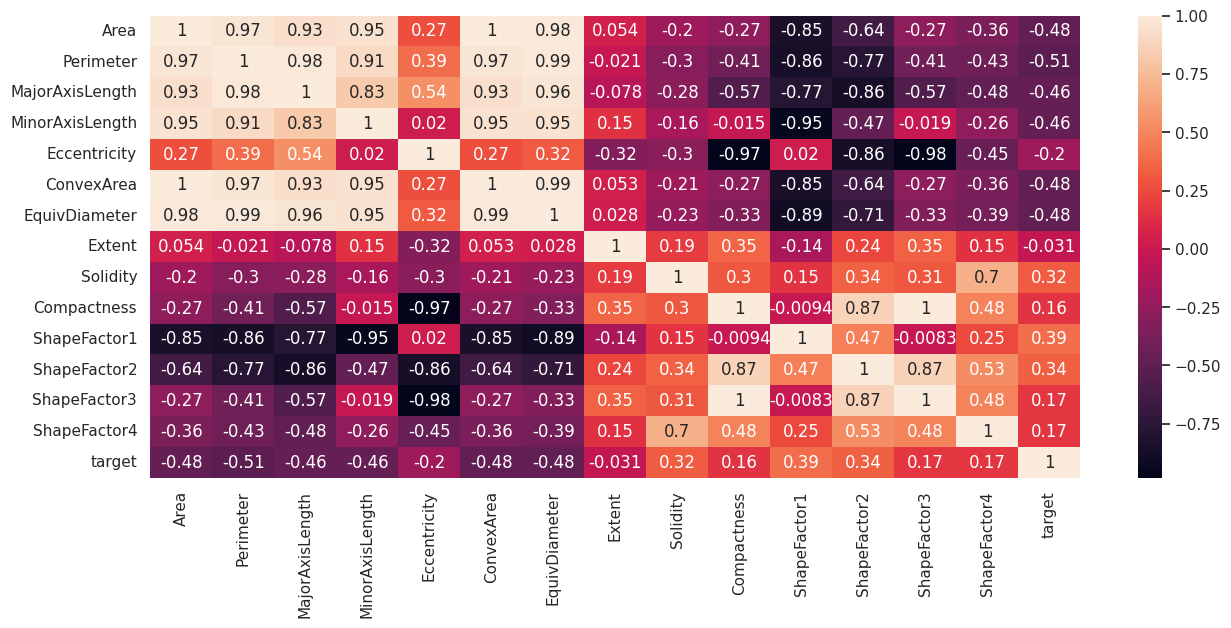

In [ ]:
plt.figure(figsize=(15, 6))
sbn.heatmap(df_copy.corr(numeric_only=True), annot=True)

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

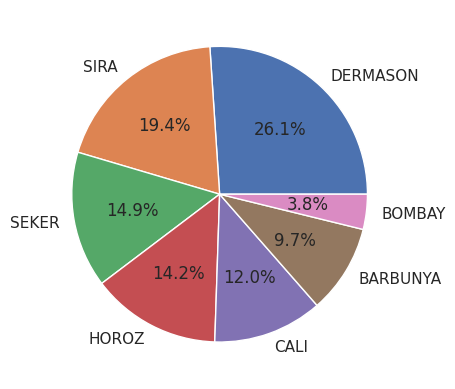

In [ ]:
plt.figure()
count_class = df_copy["Class"].value_counts()
plt.pie(count_class.values, labels=count_class.index, autopct='%1.1f%%')
df_copy["Class"].value_counts()

Vemos un desbalance en el dataset, donde la clase *SIRA* y *DERMASON* representan el 45.5% del dataset, es decir, casi la mitad. Mientras que la otra mitad está dividida entre cuatro clases.

En base a esto, podemos concluir que la métrica *Accuracy* no va a ser la mejor para medir el funcionamiento del modelo, sino que necesitaremos incluir la métrica *F1-Score*. Vamos a tratar de obtener una relación entre estas dos métricas

## Calcular Aspect Ratio (K) y Roundness (R)

In [ ]:
df_copy["Aspect Ratio"] = df_copy["MajorAxisLength"] / df_copy["MinorAxisLength"]

In [ ]:
def calc_roundness(fila):
    return (4 * math.pi * fila["Area"]) / (fila["Perimeter"] ** 2)
df_copy["Roundness"] = df_copy.apply(calc_roundness, axis=1)

## Creación del modelo

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
import optuna
import os
import random

def set_seeds(seed):  #Setear seed para obtener siempre los mismos resultados
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
set_seeds(72)

In [ ]:
## Dividir dataset
#Se elimina la columna target
dfx = df_copy.drop(columns=["target", "Class"])
dfy = df_copy["target"].astype(np.float32)
X, X_test, y, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=72)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=72)
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)
num_clases = len(df_copy["Class"].unique())

#### Fine-Tunning
Utilizamos la librería optuna para encontrar los mejores parámetros para el modelo.
Para ello necesitamos una función en donde vamos a definir nuestros posibles parámetros y luego retornamos el Accuracy y F1-Score por lo explicado anteriormente. El propósito es maximizar ambas métricas modelo que más aciertos tenga, pero que también pueda distinguir entre las diferentes clases.

In [ ]:
def objetivo_clasificacion(trial: optuna.trial.Trial):
    num_capas = trial.suggest_int("num_capas", 1, 5)
    model = Sequential()
    model.add(Input(shape=(len(X_train.columns), )))
    for i in range(num_capas):
        num_conexiones = trial.suggest_int(f"n_por_capas_{i}", 300, 1000)
        model.add(Dense(num_conexiones, activation="relu"))
    model.add(Dense(num_clases, activation="softmax"))
    model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.Accuracy(name="acc"), keras.metrics.F1Score(name="f1", average="weighted")])
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1:]

En F1Score utilizamos **average="weighted"** ya que eso da más peso a las clases minoritarias

In [ ]:
estudio_reg = optuna.create_study(directions=["maximize", "maximize"])
estudio_reg.optimize(objetivo_clasificacion, n_trials=15, show_progress_bar=False)

[I 2024-06-26 14:16:03,938] A new study created in memory with name: no-name-5768709a-3abd-4f2e-be38-8fc0538be153


Epoch 1/10
256/256 [==============================] - 11s 14ms/step - loss: 179.6758 - acc: 0.1046 - f1: 0.1436 - val_loss: 1.8340 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 2s 9ms/step - loss: 1.8345 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8348 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 2s 9ms/step - loss: 1.8348 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8363 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 2s 10ms/step - loss: 1.8347 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8339 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 3s 13ms/step - loss: 1.8347 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8349 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 3s 10ms/step - loss: 1.8344 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8372 - val_acc: 0.000

[I 2024-06-26 14:16:48,461] Trial 0 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 5, 'n_por_capas_0': 601, 'n_por_capas_1': 393, 'n_por_capas_2': 819, 'n_por_capas_3': 811, 'n_por_capas_4': 453}. 


Epoch 1/10
256/256 [==============================] - 3s 7ms/step - loss: 1535.0940 - acc: 0.7093 - f1: 0.1615 - val_loss: 498.9896 - val_acc: 0.6830 - val_f1: 0.0287
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 243.8957 - acc: 0.5814 - f1: 0.1801 - val_loss: 136.2786 - val_acc: 0.6292 - val_f1: 0.0596
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 69.9812 - acc: 0.3536 - f1: 0.2615 - val_loss: 58.7640 - val_acc: 0.3902 - val_f1: 0.1926
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 43.1021 - acc: 0.2956 - f1: 0.3129 - val_loss: 41.5039 - val_acc: 0.4424 - val_f1: 0.3261
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 25.9267 - acc: 0.2333 - f1: 0.3405 - val_loss: 3.1888 - val_acc: 0.1367 - val_f1: 0.5080
Epoch 6/10
256/256 [==============================] - 1s 4ms/step - loss: 16.0376 - acc: 0.2219 - f1: 0.4140 - val_loss: 13.2865 - val_acc: 0.1951 - val_f1: 0.2789
Epoch 7/10
2

[I 2024-06-26 14:17:10,017] Trial 1 finished with values: [0.2130003720521927, 0.3528597056865692] and parameters: {'num_capas': 2, 'n_por_capas_0': 717, 'n_por_capas_1': 881}. 


Epoch 1/10
256/256 [==============================] - 4s 6ms/step - loss: 190.6323 - acc: 0.1111 - f1: 0.1559 - val_loss: 1.8340 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 2s 8ms/step - loss: 1.8343 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8353 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8349 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8362 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8346 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8351 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8346 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8349 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8343 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8375 - val_acc: 0.0000e+00

[I 2024-06-26 14:17:27,057] Trial 2 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 5, 'n_por_capas_0': 753, 'n_por_capas_1': 411, 'n_por_capas_2': 727, 'n_por_capas_3': 641, 'n_por_capas_4': 376}. 


Epoch 1/10
256/256 [==============================] - 4s 6ms/step - loss: 313.6854 - acc: 0.1207 - f1: 0.1660 - val_loss: 3.3823 - val_acc: 0.0000e+00 - val_f1: 0.0723
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 2.3105 - acc: 0.0000e+00 - f1: 0.2276 - val_loss: 2.2354 - val_acc: 0.0000e+00 - val_f1: 0.2755
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 2.3883 - acc: 1.7494e-05 - f1: 0.2430 - val_loss: 2.0897 - val_acc: 0.0000e+00 - val_f1: 0.1430
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8713 - acc: 0.0000e+00 - f1: 0.3107 - val_loss: 2.5824 - val_acc: 0.0000e+00 - val_f1: 0.1103
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.9338 - acc: 0.0000e+00 - f1: 0.2934 - val_loss: 1.6581 - val_acc: 0.0000e+00 - val_f1: 0.2641
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 3.3725 - acc: 7.3475e-04 - f1: 0.3135 - val_loss: 5.5132 - val_acc: 0.0000e+00

[I 2024-06-26 14:17:44,415] Trial 3 finished with values: [0.0, 0.4240707457065582] and parameters: {'num_capas': 5, 'n_por_capas_0': 346, 'n_por_capas_1': 999, 'n_por_capas_2': 842, 'n_por_capas_3': 948, 'n_por_capas_4': 886}. 


Epoch 1/10
256/256 [==============================] - 4s 5ms/step - loss: 329.6154 - acc: 0.1144 - f1: 0.1446 - val_loss: 1.8347 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 2.2444 - acc: 9.9717e-04 - f1: 0.1117 - val_loss: 1.8342 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8336 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8351 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 2s 6ms/step - loss: 1.8335 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8344 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 2s 8ms/step - loss: 1.8337 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8346 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8337 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8356 - val_acc: 0.0000e+00

[I 2024-06-26 14:18:01,245] Trial 4 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 4, 'n_por_capas_0': 613, 'n_por_capas_1': 597, 'n_por_capas_2': 936, 'n_por_capas_3': 948}. 


Epoch 1/10
256/256 [==============================] - 3s 6ms/step - loss: 501.3601 - acc: 0.3949 - f1: 0.1601 - val_loss: 12.1872 - val_acc: 1.5745e-04 - val_f1: 0.0723
Epoch 2/10
256/256 [==============================] - 2s 8ms/step - loss: 3.6746 - acc: 0.0011 - f1: 0.1684 - val_loss: 1.8385 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8341 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8344 - val_acc: 0.0000e+00 - val_f1: 0.1062
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8329 - acc: 0.0000e+00 - f1: 0.1096 - val_loss: 1.8339 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8330 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8338 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8330 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8346 - val_acc: 0.0000e+00 - 

[I 2024-06-26 14:18:16,543] Trial 5 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 3, 'n_por_capas_0': 377, 'n_por_capas_1': 594, 'n_por_capas_2': 458}. 


Epoch 1/10
256/256 [==============================] - 5s 8ms/step - loss: 370.1294 - acc: 0.2631 - f1: 0.1523 - val_loss: 7.0974 - val_acc: 0.0000e+00 - val_f1: 0.0157
Epoch 2/10
256/256 [==============================] - 2s 7ms/step - loss: 2.8324 - acc: 3.4988e-05 - f1: 0.2308 - val_loss: 2.1504 - val_acc: 0.0000e+00 - val_f1: 0.2289
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8385 - acc: 0.0000e+00 - f1: 0.2648 - val_loss: 1.6680 - val_acc: 0.0000e+00 - val_f1: 0.2595
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.6692 - acc: 0.0000e+00 - f1: 0.3108 - val_loss: 1.5902 - val_acc: 0.0000e+00 - val_f1: 0.3380
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.5536 - acc: 0.0000e+00 - f1: 0.3345 - val_loss: 1.4768 - val_acc: 0.0000e+00 - val_f1: 0.2543
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.4716 - acc: 0.0000e+00 - f1: 0.3565 - val_loss: 1.3979 - val_acc: 0.0000e+00

[I 2024-06-26 14:18:35,795] Trial 6 finished with values: [0.0, 0.3716103434562683] and parameters: {'num_capas': 4, 'n_por_capas_0': 629, 'n_por_capas_1': 828, 'n_por_capas_2': 338, 'n_por_capas_3': 556}. 


Epoch 1/10
256/256 [==============================] - 3s 6ms/step - loss: 239.9921 - acc: 0.1685 - f1: 0.1564 - val_loss: 1.8342 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8334 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8343 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8340 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8351 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 2s 6ms/step - loss: 1.8339 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8346 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 2s 7ms/step - loss: 1.8341 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8348 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8340 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8363 - val_acc: 0.0000e+00

[I 2024-06-26 14:18:57,607] Trial 7 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 4, 'n_por_capas_0': 741, 'n_por_capas_1': 430, 'n_por_capas_2': 871, 'n_por_capas_3': 394}. 


Epoch 1/10
256/256 [==============================] - 3s 6ms/step - loss: 559.6728 - acc: 0.2583 - f1: 0.1733 - val_loss: 1.8556 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8365 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8338 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8345 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8340 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 1.8332 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8341 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 6ms/step - loss: 1.8332 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8348 - val_acc: 0.0000e+00

[I 2024-06-26 14:19:12,862] Trial 8 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 3, 'n_por_capas_0': 421, 'n_por_capas_1': 868, 'n_por_capas_2': 775}. 


Epoch 1/10
256/256 [==============================] - 3s 5ms/step - loss: 1596.9174 - acc: 0.7293 - f1: 0.1577 - val_loss: 621.8992 - val_acc: 0.5503 - val_f1: 0.0857
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 453.6001 - acc: 0.6731 - f1: 0.1786 - val_loss: 441.2970 - val_acc: 0.7407 - val_f1: 0.0157
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 209.2705 - acc: 0.6315 - f1: 0.2479 - val_loss: 71.1778 - val_acc: 0.5396 - val_f1: 0.2123
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 105.9794 - acc: 0.5991 - f1: 0.3024 - val_loss: 167.8009 - val_acc: 0.7318 - val_f1: 0.2151
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 77.0790 - acc: 0.5664 - f1: 0.3590 - val_loss: 52.5975 - val_acc: 0.6369 - val_f1: 0.1770
Epoch 6/10
256/256 [==============================] - 2s 6ms/step - loss: 45.2978 - acc: 0.5371 - f1: 0.4133 - val_loss: 43.3271 - val_acc: 0.5958 - val_f1: 0.2792
Epoch 7/

[I 2024-06-26 14:19:26,749] Trial 9 finished with values: [0.5281989574432373, 0.357453852891922] and parameters: {'num_capas': 2, 'n_por_capas_0': 331, 'n_por_capas_1': 650}. 


Epoch 1/10
256/256 [==============================] - 3s 5ms/step - loss: 329.0704 - acc: 0.1468 - f1: 0.2444 - val_loss: 1.6391 - val_acc: 0.0000e+00 - val_f1: 0.3656
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8037 - acc: 0.0000e+00 - f1: 0.1603 - val_loss: 1.8350 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8332 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8348 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 2s 7ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8339 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8332 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8341 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8332 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8352 - val_acc: 0.0000e+00

[I 2024-06-26 14:19:48,403] Trial 10 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 3, 'n_por_capas_0': 641, 'n_por_capas_1': 300, 'n_por_capas_2': 752}. 


Epoch 1/10
256/256 [==============================] - 2s 5ms/step - loss: 915.5884 - acc: 0.7154 - f1: 0.1743 - val_loss: 475.1170 - val_acc: 0.7586 - val_f1: 0.1439
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 510.5120 - acc: 0.7142 - f1: 0.2173 - val_loss: 369.9830 - val_acc: 0.7094 - val_f1: 0.0336
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 361.1028 - acc: 0.7121 - f1: 0.2445 - val_loss: 713.3343 - val_acc: 0.7540 - val_f1: 0.0346
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 273.2229 - acc: 0.7171 - f1: 0.2971 - val_loss: 243.0887 - val_acc: 0.7779 - val_f1: 0.1645
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 268.0209 - acc: 0.7269 - f1: 0.3109 - val_loss: 105.8016 - val_acc: 0.7663 - val_f1: 0.1991
Epoch 6/10
256/256 [==============================] - 1s 4ms/step - loss: 208.2094 - acc: 0.7140 - f1: 0.3315 - val_loss: 217.4975 - val_acc: 0.6944 - val_f1: 0.0867
Epoc

[I 2024-06-26 14:20:01,235] Trial 11 finished with values: [0.7161219120025635, 0.37115928530693054] and parameters: {'num_capas': 1, 'n_por_capas_0': 936}. 


Epoch 1/10
256/256 [==============================] - 3s 5ms/step - loss: 661.7885 - acc: 0.4494 - f1: 0.1488 - val_loss: 21.5287 - val_acc: 0.0244 - val_f1: 0.0287
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 2.2651 - acc: 1.5745e-04 - f1: 0.1202 - val_loss: 1.8476 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8416 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8387 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8364 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8357 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 2s 6ms/step - loss: 1.8343 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8346 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 2s 6ms/step - loss: 1.8334 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8345 - val_acc: 0.0000e+00 - 

[I 2024-06-26 14:20:22,898] Trial 12 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 3, 'n_por_capas_0': 980, 'n_por_capas_1': 884, 'n_por_capas_2': 393}. 


Epoch 1/10
256/256 [==============================] - 3s 5ms/step - loss: 1933.6025 - acc: 0.7316 - f1: 0.1506 - val_loss: 504.9639 - val_acc: 0.5049 - val_f1: 0.1294
Epoch 2/10
256/256 [==============================] - 1s 5ms/step - loss: 538.4315 - acc: 0.6847 - f1: 0.1711 - val_loss: 725.6714 - val_acc: 0.7706 - val_f1: 0.0723
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 270.3600 - acc: 0.6204 - f1: 0.1999 - val_loss: 108.6610 - val_acc: 0.4836 - val_f1: 0.0511
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 149.8732 - acc: 0.5622 - f1: 0.2430 - val_loss: 95.7668 - val_acc: 0.4984 - val_f1: 0.0687
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 109.1177 - acc: 0.5301 - f1: 0.2615 - val_loss: 113.5235 - val_acc: 0.5931 - val_f1: 0.0618
Epoch 6/10
256/256 [==============================] - 1s 4ms/step - loss: 63.0605 - acc: 0.4751 - f1: 0.3286 - val_loss: 41.5222 - val_acc: 0.5420 - val_f1: 0.4136
Epoch 

[I 2024-06-26 14:20:44,431] Trial 13 finished with values: [0.3267929255962372, 0.48293766379356384] and parameters: {'num_capas': 2, 'n_por_capas_0': 457, 'n_por_capas_1': 505}. 


Epoch 1/10
256/256 [==============================] - 4s 8ms/step - loss: 313.3425 - acc: 0.1111 - f1: 0.1548 - val_loss: 1.8475 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 1.8378 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8347 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 1.8334 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8345 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 4/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8339 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 5/10
256/256 [==============================] - 1s 5ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8339 - val_acc: 0.0000e+00 - val_f1: 0.1063
Epoch 6/10
256/256 [==============================] - 1s 4ms/step - loss: 1.8331 - acc: 0.0000e+00 - f1: 0.1094 - val_loss: 1.8347 - val_acc: 0.0000e+00

[I 2024-06-26 14:20:59,841] Trial 14 finished with values: [0.0, 0.10406430065631866] and parameters: {'num_capas': 3, 'n_por_capas_0': 729, 'n_por_capas_1': 367, 'n_por_capas_2': 988}. 


In [ ]:
for trial in estudio_reg.best_trials:
    print(trial.params, trial.values)

{'num_capas': 1, 'n_por_capas_0': 936} [0.7161219120025635, 0.37115928530693054]
{'num_capas': 2, 'n_por_capas_0': 457, 'n_por_capas_1': 505} [0.3267929255962372, 0.48293766379356384]


El mejor modelo encontrado es el que tiene los parámetros:
* **Número de capas**: 1
* **Neuronas por capas**: 883

Esto nos da un accuracy de 0.79 y un F1-Score de 0.41

#### Creación del modelo

In [ ]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns), )))
model.add(Dense(units=883, activation="relu"))
model.add(Dense(num_clases, activation="softmax"))
model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.Accuracy(name="acc"), keras.metrics.F1Score(name="f1", average="weighted")])
model_history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size=32)
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/15
256/256 [==============================] - 2s 5ms/step - loss: 910.6904 - acc: 0.7111 - f1: 0.1728 - val_loss: 339.6404 - val_acc: 0.7526 - val_f1: 0.0324
Epoch 2/15
256/256 [==============================] - 1s 4ms/step - loss: 497.1278 - acc: 0.7124 - f1: 0.2191 - val_loss: 392.9102 - val_acc: 0.7860 - val_f1: 0.1088
Epoch 3/15
256/256 [==============================] - 1s 4ms/step - loss: 303.7701 - acc: 0.7020 - f1: 0.2659 - val_loss: 318.2504 - val_acc: 0.6937 - val_f1: 0.0339
Epoch 4/15
256/256 [==============================] - 1s 4ms/step - loss: 293.3352 - acc: 0.7140 - f1: 0.2891 - val_loss: 377.5310 - val_acc: 0.7818 - val_f1: 0.1515
Epoch 5/15
256/256 [==============================] - 1s 4ms/step - loss: 213.7049 - acc: 0.7067 - f1: 0.3220 - val_loss: 218.9522 - val_acc: 0.6477 - val_f1: 0.0175
Epoch 6/15
256/256 [==============================] - 1s 4ms/step - loss: 224.3109 - acc: 0.7202 - f1: 0.3256 - val_loss: 186.8399 - val_acc: 0.7419 - val_f1: 0.2566
Epoc

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 883)               15011     
                                                                 
 dense_65 (Dense)            (None, 7)                 6188      
                                                                 
Total params: 21199 (82.81 KB)
Trainable params: 21199 (82.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print("Pérdida", score[0])
print("Accuracy", score[1])
print("F1", score[2])

Pérdida 91.0218276977539
Accuracy 0.7720476388931274
F1 0.2719900608062744


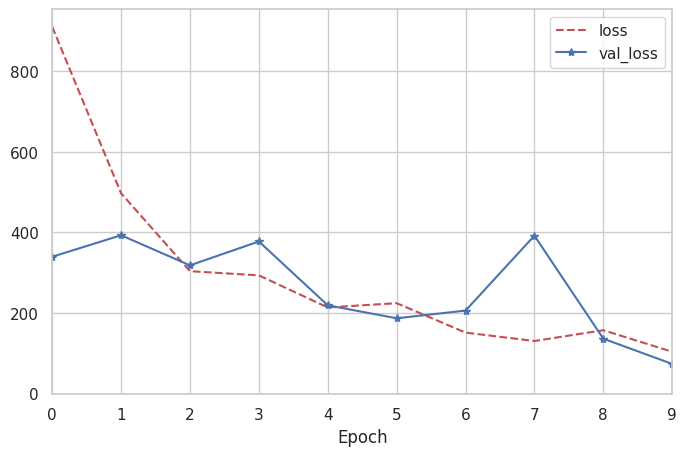

In [ ]:
pd.DataFrame({"loss": model_history.history["loss"], "val_loss": model_history.history["val_loss"]}).plot(figsize=(8, 5), xlim=[0, 9],  grid=True, xlabel="Epoch", style=["r--", "b-*"])
plt.show()

En el gráfico superior podemos apreciar la evoluación de la pérdida a través de las iteraciones. Vemos que la pérdida de validación es menor a la de entrenamiento

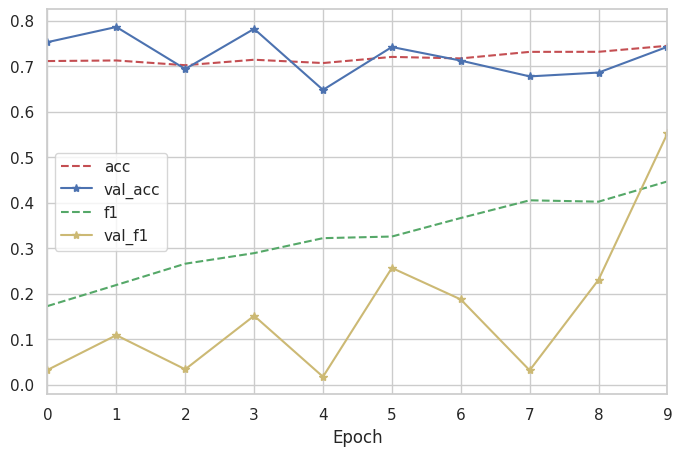

In [ ]:
pd.DataFrame({
    "acc": model_history.history["acc"],
    "val_acc": model_history.history["val_acc"],
    "f1": model_history.history["f1"],
    "val_f1": model_history.history["val_f1"]
}).plot(figsize=(8, 5), xlim=[0, 9],  grid=True, xlabel="Epoch", style=["r--", "b-*", "g--", "y-*"])
plt.show()

En el gráfico vemos la evolución de nuestras métricas de rendimiento. Vemos que, al finalizar las iteraciones, el f1 de validation es superior al de training y el accuracy de validation está sólo un poco debajo del de training

#### Comparación con modelo sin darle pesos a las clases

Primero entrenamos al modelo quitandole la ponderacion de las clases minoritarias

In [ ]:
model_without_weight = Sequential()
model_without_weight.add(Input(shape=(len(X_train.columns), )))
model_without_weight.add(Dense(units=883, activation="relu"))
model_without_weight.add(Dense(num_clases, activation="softmax"))
model_without_weight.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.Accuracy(name="acc"), keras.metrics.F1Score(name="f1")])
model_without_weight_history = model_without_weight.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size=32)
score_model_without_weight = model_without_weight.evaluate(X_test, y_test, verbose=0)

Epoch 1/15
256/256 [==============================] - 2s 6ms/step - loss: 1010.1618 - acc: 0.7201 - f1: 0.1409 - val_loss: 935.8559 - val_acc: 0.7404 - val_f1: 0.0242
Epoch 2/15
256/256 [==============================] - 1s 6ms/step - loss: 672.6159 - acc: 0.7231 - f1: 0.1759 - val_loss: 928.6100 - val_acc: 0.7517 - val_f1: 0.0338
Epoch 3/15
256/256 [==============================] - 1s 4ms/step - loss: 308.1334 - acc: 0.6992 - f1: 0.2197 - val_loss: 173.5235 - val_acc: 0.7597 - val_f1: 0.1340
Epoch 4/15
256/256 [==============================] - 1s 4ms/step - loss: 352.3340 - acc: 0.7162 - f1: 0.2513 - val_loss: 779.2555 - val_acc: 0.7746 - val_f1: 0.1537
Epoch 5/15
256/256 [==============================] - 1s 4ms/step - loss: 276.9935 - acc: 0.7108 - f1: 0.2663 - val_loss: 184.4011 - val_acc: 0.7811 - val_f1: 0.1809
Epoch 6/15
256/256 [==============================] - 1s 4ms/step - loss: 229.6886 - acc: 0.7238 - f1: 0.3087 - val_loss: 65.7233 - val_acc: 0.6787 - val_f1: 0.3116
Epoc

In [ ]:
print(model_without_weight.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 883)               15011     
                                                                 
 dense_67 (Dense)            (None, 7)                 6188      
                                                                 
Total params: 21199 (82.81 KB)
Trainable params: 21199 (82.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
print("Pérdida", score_model_without_weight[0])
print("Accuracy", score_model_without_weight[1])
print("F1", score_model_without_weight[2])

Pérdida 59.95304870605469
Accuracy 0.8178479671478271
F1 [0.         1.         0.6899563  0.82172704 0.         0.
 0.488024  ]


Hacemos las predicciones de cada modelo para comparar

In [ ]:
# Predicciones del modelo sin ponderación
predicciones_model_without_weight = model_without_weight.predict(X_test)
y_pred_without_weight = predicciones_model_without_weight.argmax(axis=1)


# Predicciones del modelo con ponderación
predicciones_model = model.predict(X_test)
y_pred = predicciones_model.argmax(axis=1)


y_test_labels = y_test.argmax(axis=1)

86/86 [==============================] - 0s 2ms/step


Creamos las matrices de confucion de cada modelo

In [ ]:
# Matriz de confusión para el modelo sin ponderación
matriz_confusion_without_weight = confusion_matrix(y_test_labels, y_pred_without_weight)

# Matriz de confusión para el modelo con ponderación
matriz_confusion = confusion_matrix(y_test_labels, y_pred)

Comparamos la matriz de confusión de cada modelo para ver lo que obtenemos

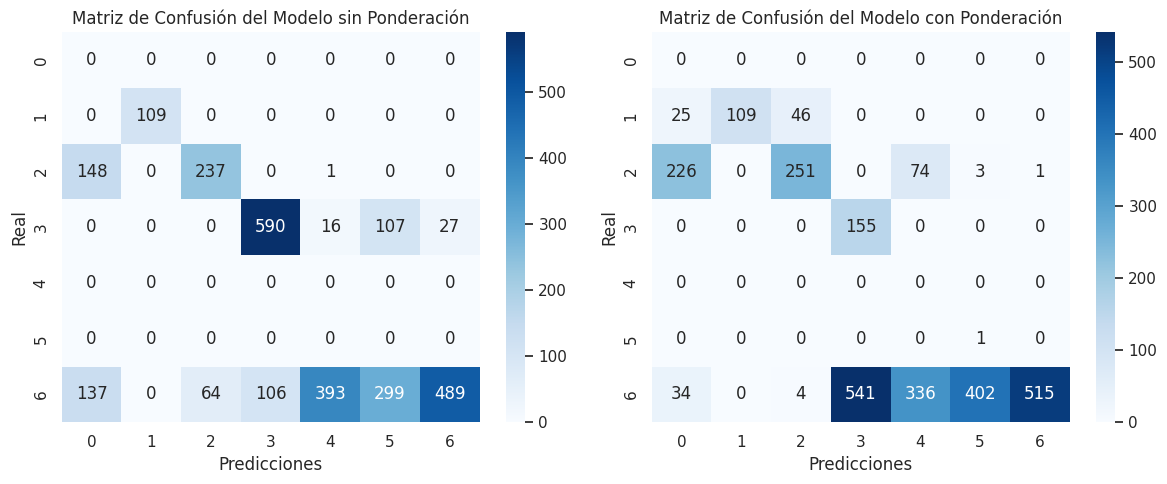

In [ ]:
# Visualización de la matriz de confusión del modelo sin ponderación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sbn.heatmap(matriz_confusion_without_weight.T, annot=True, fmt='d', cmap="Blues")
plt.title('Matriz de Confusión del Modelo sin Ponderación')
plt.xlabel('Predicciones')
plt.ylabel('Real')

# Visualización de la matriz de confusión del modelo con ponderación
plt.subplot(1, 2, 2)
sbn.heatmap(matriz_confusion.T, annot=True, fmt='d', cmap="Blues")
plt.title('Matriz de Confusión del Modelo con Ponderación')
plt.xlabel('Predicciones')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

### Conclusión
Este trabajo práctico ha demostrado la eficacia del uso de redes neuronales para clasificar diferentes variedades de frijoles secos basándose en características morfológicas. Al agregar nuevas características calculadas como el índice de aspecto y la redondez al conjunto de datos, hemos mejorado la capacidad predictiva del modelo de clasificación. Estas nuevas características proporcionan una mayor comprensión de la forma y estructura de los granos de frijol, lo que contribuye a una clasificación más precisa. El modelo entrenado ha demostrado ser capaz de distinguir con una precisión aceptable entre siete variedades de frijoles secos, lo que sugiere su potencial aplicación en la industria agrícola para la clasificación automatizada de cosechas. El principal problema que encontramos en este dataset es que se encontraba desbalanceado, sin embargo, pudimos solucionarlo realizando dos métricas diferentes: Accuracy y F1-Score.

Para evaluar el impacto del desbalanceo en el rendimiento del modelo, se realizaron dos experimentos: uno con ponderación y otro sin ponderación.

El modelo sin ponderación mostró una pérdida de 59.9530, una precisión (accuracy) de 0.8178 y F1 Scores que variaron significativamente entre las clases. Este modelo tuvo un buen rendimiento general, especialmente en la clase 3, pero presentó dificultades para predecir correctamente ciertas clases (0, 4 y 5).

Por otro lado, el modelo con ponderación tuvo una pérdida mayor de 91.0218 y una precisión (accuracy) de 0.7720, con un F1 Score global de 0.2719. Este modelo intentó abordar el desbalanceo entre las clases, lo que resultó en una mayor confusión en algunas clases y una menor precisión global.

En resumen, el modelo sin ponderación logró una mayor precisión global, mientras que el modelo con ponderación mostró un intento de mejorar el manejo del desbalanceo entre las clases. La elección del modelo adecuado dependerá de la prioridad dada a la precisión global versus la equidad en la clasificación de todas las clases. Estos resultados destacan la importancia de considerar el balance de clases en problemas de clasificación y de utilizar métricas complementarias para evaluar el rendimiento del modelo.

# Ejercicio 3
## Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

Dataset:
El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street
Las imágenes están divididas en tres conjuntos:
* Train: Alrededor de 14,000 imágenes para entrenamiento.
* Test: Alrededor de 3,000 imágenes para evaluación del modelo.
* Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
* Modelo con capas densas.
* Modelo con capas convolucionales y densas.
* Modelo que incluya bloques residuales identidad:
* Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.



## Configuración

In [2]:
!pip install gdown

In [3]:
import gdown
import zipfile
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, Add
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix

Descargamos el set de datos

In [4]:
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=4e326a94-f786-40e0-b70c-177d0fc9817b
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:08<00:00, 41.9MB/s]


## Análisis del set de datos

Se definen los directorios de entrenamiento, validación y prueba del modelo

In [5]:
train_dir = 'TP1-3/seg_train/seg_train'
val_dir = 'TP1-3/seg_test/seg_test'
test_dir = 'TP1-3/seg_pred'

Visualizamos la cantidad de datos de cada clase para entrenamiento y test

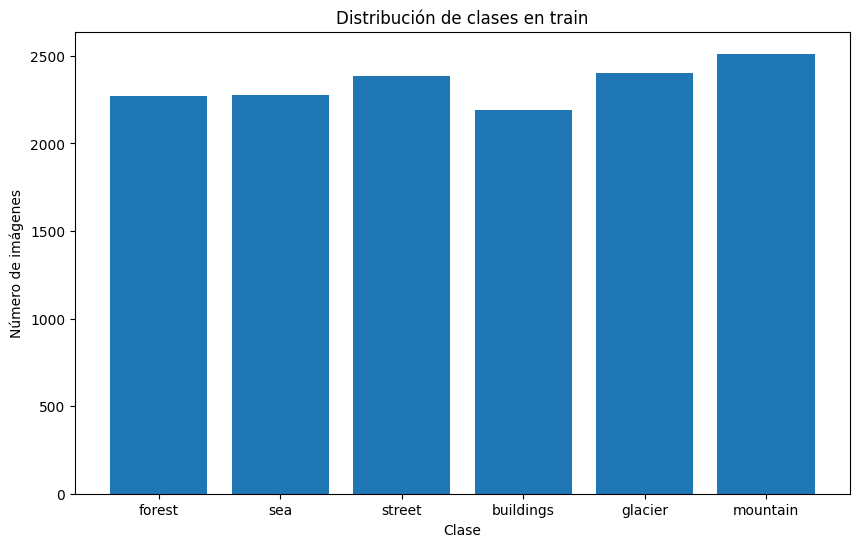

In [6]:
classes = os.listdir(train_dir)

num_images_per_class = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    num_images_per_class[class_name] = num_images

plt.figure(figsize=(10, 6))
plt.bar(num_images_per_class.keys(), num_images_per_class.values())
plt.title('Distribución de clases en train')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.show()

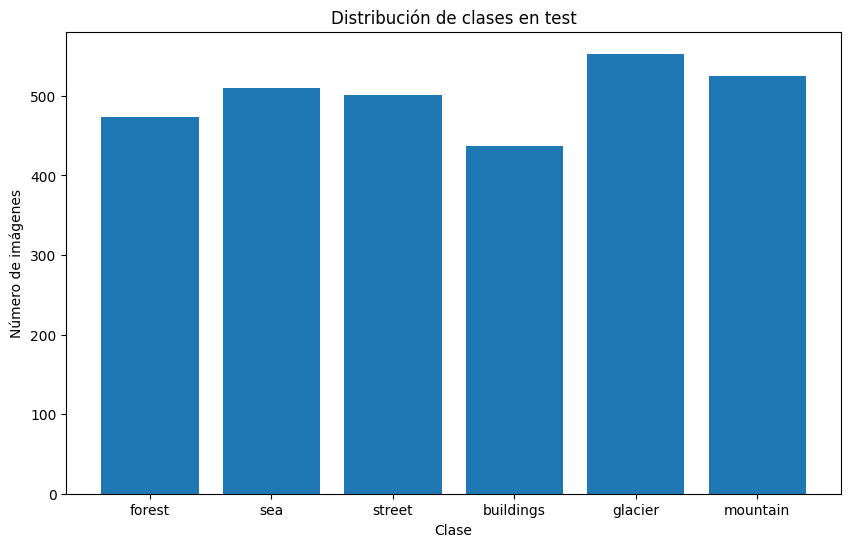

In [7]:
num_images_per_class = {}
for class_name in classes:
    class_path = os.path.join(val_dir, class_name)
    num_images = len(os.listdir(class_path))
    num_images_per_class[class_name] = num_images

plt.figure(figsize=(10, 6))
plt.bar(num_images_per_class.keys(), num_images_per_class.values())
plt.title('Distribución de clases en test')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.show()

Observamos algunos ejemplos de las clases que vamos a trabajar

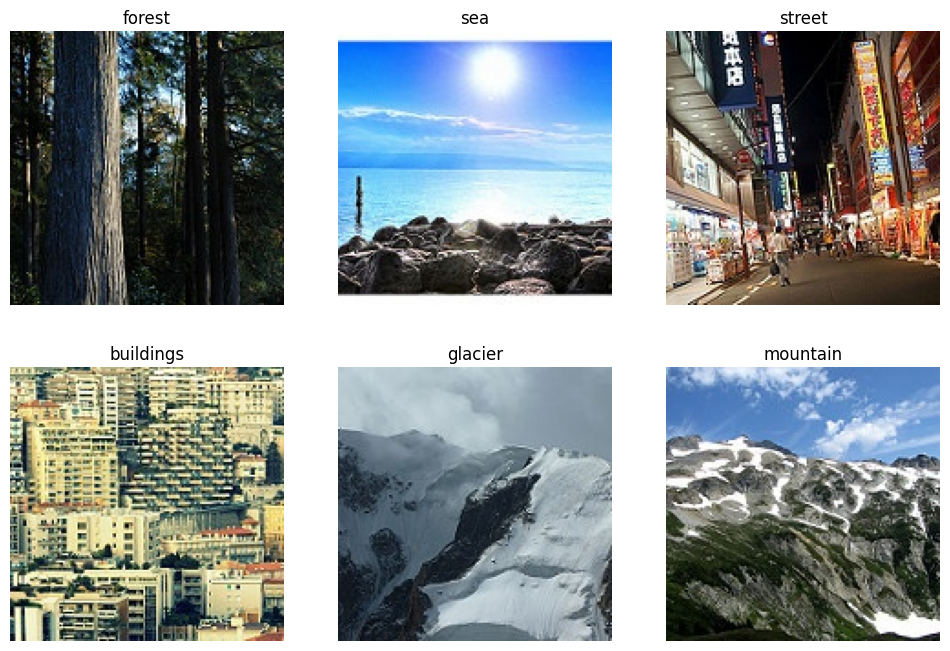

In [8]:
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(classes, start=1):
    class_path = os.path.join(train_dir, class_name)
    sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])
    sample_image = load_img(sample_image_path, target_size=(150, 150))
    plt.subplot(2, 3, i)
    plt.imshow(sample_image)
    plt.title(class_name)
    plt.axis('off')
plt.show()

Por último unas estadísticas básicas para poder obtener una visión más general del set de datos

In [9]:
total_images = sum(num_images_per_class.values())
print("Número total de imágenes:", total_images)
print("Número de clases:", len(classes))
print("Número promedio de imágenes por clase:", np.mean(list(num_images_per_class.values())))
print("Tamaño promedio de las imágenes:", sample_image.size)

Número total de imágenes: 3000
Número de clases: 6
Número promedio de imágenes por clase: 500.0
Tamaño promedio de las imágenes: (150, 150)


## Creación de modelos

Definimos los set de datos que utilizaremos en los modelos

In [10]:
batch_size = 32
target_size = (150, 150)

# Generador de datos de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generador de datos de validación
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generador de datos de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


### Modelos con capas densas

Definimos el modelo con capas densas

In [11]:
dense_model = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 8648774 (32.99 MB)
Trainable params: 8648774 (32.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo

In [13]:
history_dense_model = dense_model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15
439/439 [==============================] - 81s 180ms/step - loss: 2.5145 - accuracy: 0.3972 - val_loss: 1.6062 - val_accuracy: 0.3557
Epoch 2/15
439/439 [==============================] - 82s 187ms/step - loss: 1.4224 - accuracy: 0.4587 - val_loss: 1.3946 - val_accuracy: 0.4660
Epoch 3/15
439/439 [==============================] - 78s 178ms/step - loss: 1.3539 - accuracy: 0.4885 - val_loss: 1.2724 - val_accuracy: 0.5313
Epoch 4/15
439/439 [==============================] - 80s 182ms/step - loss: 1.2934 - accuracy: 0.5058 - val_loss: 1.2293 - val_accuracy: 0.5257
Epoch 5/15
439/439 [==============================] - 78s 178ms/step - loss: 1.2795 - accuracy: 0.5092 - val_loss: 1.2700 - val_accuracy: 0.5260
Epoch 6/15
439/439 [==============================] - 82s 186ms/step - loss: 1.2756 - accuracy: 0.5133 - val_loss: 1.2390 - val_accuracy: 0.5397
Epoch 7/15
439/439 [==============================] - 79s 179ms/step - loss: 1.2308 - accuracy: 0.5356 - val_loss: 1.2228 - val_ac

Evaluamos al modelo

In [14]:
dense_loss, dense_accuracy = dense_model.evaluate(val_generator)
print("Dense Model Accuracy:", dense_accuracy)

94/94 [==============================] - 3s 27ms/step - loss: 1.1711 - accuracy: 0.5617
Dense Model Accuracy: 0.5616666674613953


Vemos como se comportó a lo largo del entrenamiento

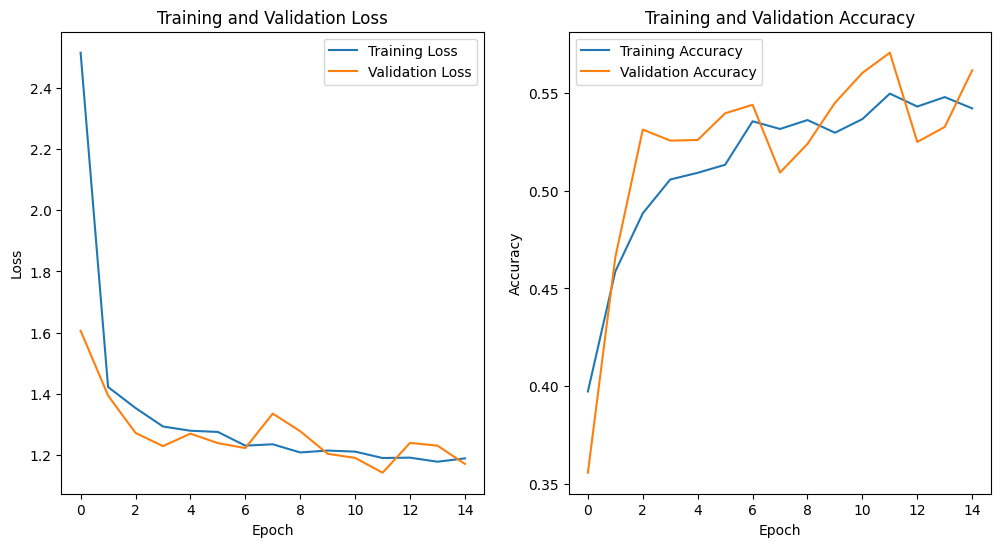

In [15]:
def see_history_model(history):
  train_loss = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

see_history_model(history_dense_model)

### Modelo con capas convolucionales y densas

Definimos el modelo con capas convolucionales y densas

In [16]:
conv_dense_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

conv_dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
conv_dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

Lo entrenamos

In [18]:
history_conv_dense_model = conv_dense_model.fit(train_generator, epochs=8, validation_data=val_generator)

Epoch 1/8
439/439 [==============================] - 89s 192ms/step - loss: 1.0067 - accuracy: 0.6068 - val_loss: 0.8531 - val_accuracy: 0.6773
Epoch 2/8
439/439 [==============================] - 84s 191ms/step - loss: 0.7340 - accuracy: 0.7307 - val_loss: 0.8637 - val_accuracy: 0.7193
Epoch 3/8
439/439 [==============================] - 84s 191ms/step - loss: 0.5977 - accuracy: 0.7823 - val_loss: 0.5724 - val_accuracy: 0.7903
Epoch 4/8
439/439 [==============================] - 85s 193ms/step - loss: 0.5175 - accuracy: 0.8115 - val_loss: 0.5737 - val_accuracy: 0.7960
Epoch 5/8
439/439 [==============================] - 84s 192ms/step - loss: 0.4679 - accuracy: 0.8278 - val_loss: 0.4688 - val_accuracy: 0.8377
Epoch 6/8
439/439 [==============================] - 84s 191ms/step - loss: 0.4238 - accuracy: 0.8457 - val_loss: 0.5013 - val_accuracy: 0.8230
Epoch 7/8
439/439 [==============================] - 83s 189ms/step - loss: 0.3933 - accuracy: 0.8591 - val_loss: 0.4449 - val_accuracy:

Evaluamos el modelo

In [19]:
conv_dense_loss, conv_dense_accuracy = conv_dense_model.evaluate(val_generator)
print("Convolutional + Dense Model Accuracy:", conv_dense_accuracy)

94/94 [==============================] - 3s 30ms/step - loss: 0.4262 - accuracy: 0.8510
Convolutional + Dense Model Accuracy: 0.8510000109672546


Vemos como se comportó a lo largo del entrenamiento

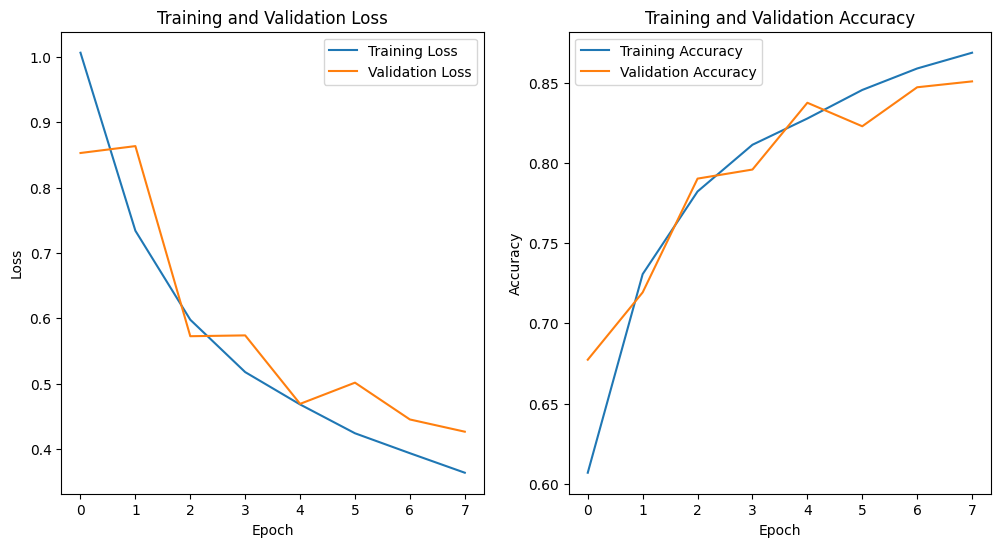

In [20]:
see_history_model(history_conv_dense_model)

### Modelo residual

Definimos el modelo residual

In [21]:
def residual_block(x, filters, kernel_size):
    y = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters, kernel_size, padding='same', activation='linear')(y)
    y = BatchNormalization()(y)

    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same')(x)

    y = Add()([y, x])
    y = tf.keras.layers.Activation('relu')(y)
    return y

input_layer = Input(shape=(150, 150, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = residual_block(x, 32, (3, 3))
x = MaxPooling2D(2, 2)(x)
x = residual_block(x, 64, (3, 3))
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(6, activation='softmax')(x)

residual_model = Model(inputs=input_layer, outputs=output_layer)
residual_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
residual_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 148, 148, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 74, 74, 32)           9248      ['max_pooling2d_3[0][0]'] 

Lo entrenamos

In [23]:
history_residual_model = residual_model.fit(train_generator, epochs=8, validation_data=val_generator)

Epoch 1/8
439/439 [==============================] - 90s 194ms/step - loss: 1.0167 - accuracy: 0.6488 - val_loss: 1.9243 - val_accuracy: 0.3943
Epoch 2/8
439/439 [==============================] - 87s 198ms/step - loss: 0.6414 - accuracy: 0.7650 - val_loss: 0.8282 - val_accuracy: 0.7097
Epoch 3/8
439/439 [==============================] - 87s 198ms/step - loss: 0.5569 - accuracy: 0.7961 - val_loss: 1.1395 - val_accuracy: 0.5973
Epoch 4/8
439/439 [==============================] - 84s 192ms/step - loss: 0.4924 - accuracy: 0.8203 - val_loss: 3.3413 - val_accuracy: 0.3667
Epoch 5/8
439/439 [==============================] - 85s 192ms/step - loss: 0.4586 - accuracy: 0.8355 - val_loss: 0.7489 - val_accuracy: 0.7543
Epoch 6/8
439/439 [==============================] - 87s 197ms/step - loss: 0.4327 - accuracy: 0.8431 - val_loss: 0.6062 - val_accuracy: 0.7740
Epoch 7/8
439/439 [==============================] - 87s 198ms/step - loss: 0.3963 - accuracy: 0.8554 - val_loss: 1.0685 - val_accuracy:

Evaluamos el modelo

In [24]:
residual_loss, residual_accuracy = residual_model.evaluate(val_generator)
print("Residual Model Accuracy:", residual_accuracy)

94/94 [==============================] - 3s 34ms/step - loss: 0.5672 - accuracy: 0.8070
Residual Model Accuracy: 0.8069999814033508


Vemos como se comportó el modelo a lo largo del entrenamiento

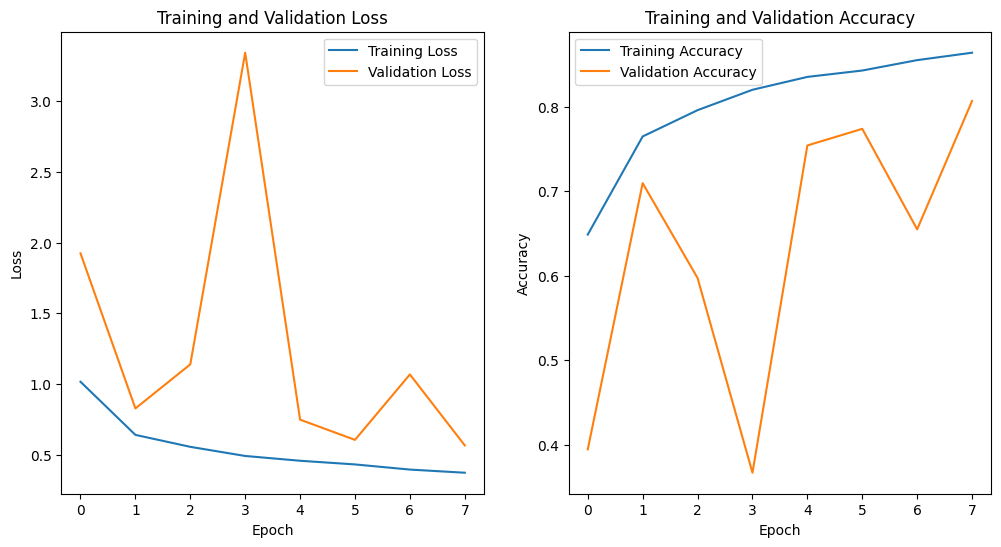

In [25]:
see_history_model(history_residual_model)

### Modelo con Transfer Learning

Definimos el modelo con Transfer Learning

En este caso elegimos a ResNet50 como Backbone

In [26]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [27]:
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

Lo entrenamos

In [28]:
history_transfer_model = transfer_model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
439/439 [==============================] - 101s 217ms/step - loss: 1.2600 - accuracy: 0.4864 - val_loss: 0.9849 - val_accuracy: 0.6080
Epoch 2/30
439/439 [==============================] - 94s 213ms/step - loss: 1.0194 - accuracy: 0.5904 - val_loss: 1.0821 - val_accuracy: 0.5547
Epoch 3/30
439/439 [==============================] - 93s 211ms/step - loss: 0.9340 - accuracy: 0.6303 - val_loss: 0.8886 - val_accuracy: 0.6490
Epoch 4/30
439/439 [==============================] - 93s 211ms/step - loss: 0.9410 - accuracy: 0.6245 - val_loss: 0.9318 - val_accuracy: 0.6257
Epoch 5/30
439/439 [==============================] - 93s 211ms/step - loss: 0.8937 - accuracy: 0.6447 - val_loss: 0.8911 - val_accuracy: 0.6330
Epoch 6/30
439/439 [==============================] - 96s 219ms/step - loss: 0.8787 - accuracy: 0.6501 - val_loss: 0.8247 - val_accuracy: 0.6650
Epoch 7/30
439/439 [==============================] - 92s 210ms/step - loss: 0.8536 - accuracy: 0.6652 - val_loss: 0.7792 - val_a

Evaluamos el modelo

In [29]:
transfer_loss, transfer_accuracy = transfer_model.evaluate(val_generator)
print("Transfer Learning Model Accuracy:", transfer_accuracy)

94/94 [==============================] - 6s 59ms/step - loss: 0.7181 - accuracy: 0.7280
Transfer Learning Model Accuracy: 0.7279999852180481


Veamos como se comportó el modelo a lo largo del entrenamiento

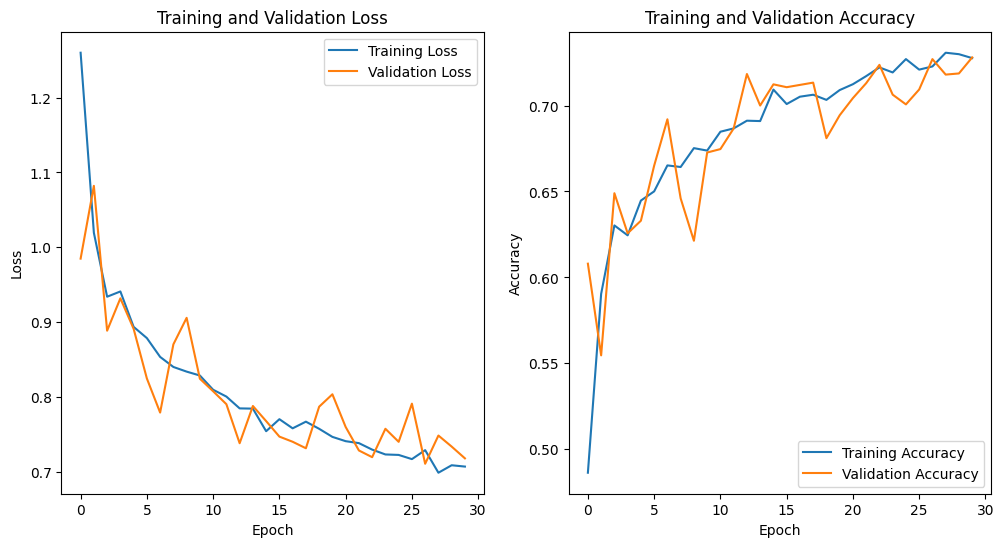

In [30]:
see_history_model(history_transfer_model)

## Selección del mejor modelo y predicción

Comparando las métricas de los modelos nos queda de la siguiente manera

In [31]:
print("Comparación de accuracy")
print(f"Modelo de capas densas: {dense_accuracy}")
print(f"Modelo de capas densas y convolucionales: {conv_dense_accuracy}")
print(f"Modelo con bloques residuales de identidad: {residual_accuracy}")
print(f"Modelo de transfer learning: {transfer_accuracy}")

Comparación de accuracy
Modelo de capas densas: 0.5616666674613953
Modelo de capas densas y convolucionales: 0.8510000109672546
Modelo con bloques residuales de identidad: 0.8069999814033508
Modelo de transfer learning: 0.7279999852180481


Viendo las métricas que fueron obteniendo los modelos nos interesará quedarnos con el que más accuracy obtuvo, en este caso fue el modelo de capas densas y convolucionales obtuviendo un 0.86 de accuracy

In [32]:
# Predecir con el mejor modelo
predictions = conv_dense_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Guardar las predicciones en un archivo
np.savetxt("predictions.csv", predicted_classes, delimiter=",", fmt='%d')

# Guardar el mejor modelo
conv_dense_model.save("best_model.h5")

7301/7301 [==============================] - 19s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Conclusión

Una vez finalizado este ejercicios podemos concluir con que el modelo de capas densas y convolucionales es el mejor pero debemos detallar características importantes de todos los modelos testeados:

* Modelo de capas densas: Este modelo obtuvo el menor accuracy, alrededor del 0.53, Esto nos demuestra que las capas densas por sí solas pueden no ser suficientes para capturar las características más complejas que están presentes en las imágenes que le suministramos al modelo.
* Modelo de capas densas y convolucionales: Este modelo obtuvo un accuracy mucho mayor que el anterior siendo de 0.86. La incorporación de capas convolucionales nos permitió que el modelo pueda mejor las características más complejas de las imágenes.
* Modelo con bloques residuales de identidad: Este modelo obtuvo un accuracy del 0.77, lo que nos indica un rendimiento sólido pero no tan alto como el modelo con capas densas y convolucionales. Los bloques residuales ayudaron a abordar el problema de degradación del rendimiento que puede ocurrir en redes neuronales muy profundas.
* Modelo de transfer learning: Este modelo alcanzó un accuracy del 0.73, aunque este valor es menor en comparación con el modelo de capas densas y convolucionales, sigue siendo una opción viable, especialmente si tenemos en cuenta la facilidad de implementación y la capacidad de utilizar modelos pre-entrenados para tareas de clasificación de imágenes de una manera más fácil.

En general el modelo de capas densas y convolucionales supera a los otros modelos en términos de precisión aunque puede variar dependiendo de factores tales como el tiempo de entrenamiento requerrido, la complejidad del modelo y de los recursos que tengamos disponibles.
